# Introduction

This file first aims to compare different (basic) constraints in portfolio optimisaion, based on their performances: allocation diversity, return, Sharpe ratio. We will focus on the long-only, L/S and leverage constaints with a simple MV optimisation problem. 

Secondly, viewing the poor diversity of the allocations, we add a risk aversion parameter to the Markowitz problem simuation. We find the best value of it over the first semester of 2025.

The basket of assets we use is the CAC40 (the top 40 french firms with biggest capitalisation).

### Libraries

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy.optimize import minimize_scalar

### Data loading and preparation

In [73]:
# cac40.csv contains adjusted close prices from 2022 Jan to 2025 June 
cac40 = pd.read_csv('cac40.csv',index_col="Date")
cac40_evolution = cac40['^FCHI']/cac40['^FCHI'].iloc[0]

returns = cac40.drop(columns=['^FCHI']).pct_change().dropna()
tickers = returns.columns
T,N = returns.shape

# In sample - 2022 Jan to 2024 Dec.
returns_insample = returns.loc[:'2025-01-01']
T_in,_ = returns_insample.shape

# Out of sample - two first quarters of 2025
returns_outsample = returns.loc['2025-01-01':]
T_out,_ = returns_outsample.shape

# Problems optimisation

We approximate the mean of the return by the sample mean, assuming $N_{in} = 438$ is high enough. Similarly, we approximate the covariance matrix by the sample one.

Then we compute the solution of the Markowitz formulation: 

$\quad\min_{w} w^T\Sigma w - \mu^T w $

For three different constraints: 
- Long-only: $w^T1=1$ and $w>=0$
- Long/Short: $w^T1=1$
- Long/Short with leverage constraint: $w^T1=1$ and $\|w\|_1\leq 2$

In [74]:
# Compute mean and vairance
mu = returns_insample.mean().to_numpy()
Sigma = returns_insample.cov().to_numpy()
w = cvx.Variable(N)
objective = cvx.Minimize(cvx.quad_form(w,Sigma) - w.T@mu)

# Long-only 
constraints = [ w >= 0 , cvx.sum(w) == 1]
long_only_pb = cvx.Problem(objective,constraints)
long_only_pb.solve()
w_lo = w.value

# Long/Short, no levrage constaint
constraints = [ cvx.sum(w) == 1]
long_short_pb = cvx.Problem(objective,constraints)
long_short_pb.solve()
w_ls = w.value

# Long-Short, leverage fixed at 2
constraints = [ cvx.sum(w) == 1, cvx.norm1(w) <= 2]
leverage_pb = cvx.Problem(objective,constraints)
leverage_pb.solve()
w_l2 = w.value

# Results 
col_names = ["Long-only","Long/Short","Leverage-limited"]
weights = np.array([w_lo,w_ls,w_l2]).T
weights= np.round(weights,4)

# Portfolios comparison

First, let's take a glance at the different allocations

In [75]:
weights = pd.DataFrame(weights,index=tickers,columns=col_names)
weights

,Long-only,Long/Short,Leverage-limited
AC.PA,-0.0,2.9005,0.1373
ACA.PA,0.0,2.9775,-0.0000
AI.PA,0.0,-1.3477,0.0000
AIR.PA,0.0,0.5138,0.0000
BN.PA,-0.0,5.1257,0.0000
BNP.PA,0.0,-0.7782,-0.0000
BVI.PA,0.0,-1.1592,-0.0000
CA.PA,0.0,-1.5972,-0.0000
CAP.PA,0.0,1.1641,-0.0000
CS.PA,0.0,0.7241,0.0000


First observation: the long-only portfolio contains only one stock and the L/S one took position for every single stock!

Now, let's compute the evolution of the wealth of each portfolio compared to the market (CAC40).

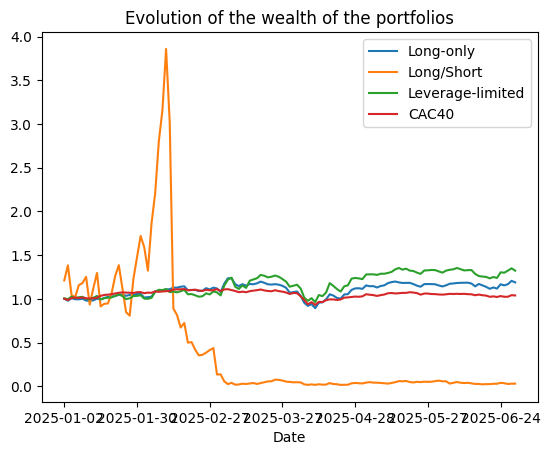

In [76]:
# Wealth evolution
portfolios_returns = returns_outsample@weights
portfolios_returns['CAC40'] = cac40_evolution.pct_change().dropna()
portfolios_evolution = (1+portfolios_returns).cumprod()

portfolios_evolution.plot()
plt.title('Evolution of the wealth of the portfolios')
plt.show()

Everyone can see that the L/S portfolio without any leverage constaint performs terribly. By looking in details in the computed weights, we found out that some risky short positions have been taken, that finally turned out badly. We can cite Danone (DG.PA) and Legrand SA (LR.PA) weighted respectively at -456% and -393%. 

Let's drop the L/S portfolio without leverage constraint and compare more attentively the two remaining allocations.

In [77]:
# Allocation analysis
allocation = weights[(weights[["Long-only","Leverage-limited"]]!=0).any(axis=1)]
print(allocation[["Long-only","Leverage-limited"]])

        Long-only  Leverage-limited
AC.PA        -0.0            0.1373
KER.PA       -0.0           -0.4399
SAF.PA       -0.0            0.0167
SGO.PA        1.0            1.2602
SU.PA         0.0            0.0859
TEP.PA       -0.0           -0.0601


In [78]:
# (Annualised) performances
annualised_returns = 252*portfolios_returns.mean()
annualised_std = np.sqrt(252)*portfolios_returns.std()

r_f = 0.024                     # Livret A (French savings account) returns for Q1 and Q2 of 2025
annualised_SR = (annualised_returns-r_f)/annualised_std

# Maximum drawdown
mdd = (portfolios_evolution/portfolios_evolution.cummax()-1).min()

# VaR and CVaR with L = - r@w
alpha = 0.95
loss = - portfolios_returns
var = loss.quantile(alpha)             # VaR = Q_L(0.95) = Q_r(0.05)
cvar = (loss[loss>=var]).mean()        # CVaR = E[L|L>=VaR]

# Summary of metrics
number = (weights!=0).sum()
number['cac40'] = 40
#print(number,annualised_returns,annualised_std,annualised_SR,mdd,var,cvar)
summary = np.array([number,annualised_returns,annualised_std,annualised_SR,mdd,var,cvar]).T
summary = pd.DataFrame(np.round(summary,4),index=portfolios_returns.columns,columns=['number','return','std','SR','MDD','VaR','CVaR'])
print(summary)

                  number  return     std      SR     MDD     VaR    CVaR
Long-only            1.0  0.4191  0.3786  1.0435 -0.2771  0.0393  0.0511
Long/Short          40.0  2.6125  4.1801  0.6192 -0.9961  0.4407  0.5821
Leverage-limited     6.0  0.6744  0.4735  1.3737 -0.2440  0.0373  0.0560
CAC40               40.0  0.0940  0.1877  0.3730 -0.1637  0.0157  0.0297


The long-only consists in only one stock, Saint-Gobain (SGO.PA), and the leverage-limited one has only 6 stocks. Hence the conclusion is that they are both very risky from a diversification point of view. Indeed, 4 among those 6 are in the the sector fo Industiral according to GICS. This risk is clearly captured by the very high standard deviations of those portfolio compared to the market: more than twice more risky!

Although they are risky, these portfolios are very effective, having 41.91% and 67.44% in annualised average returns during one semester. Finally, we compute their sharpe ratio using the french saving account (fixed at an annualised interest rate of 2.4% during 2025 first semester). Due to their bad standard deviation, the Sharpe ratio of the Long-Only and leverage-limited are not that good and don't allow to pick one performative allocation.

Finally, the Long/Short leverage-limited portfolio is a first step toward a portfolio fixed allocation. A dynamic allocation will be the topic of another latter file. For instance, we will try to diversify this portfolio by balancing the mean and variance in the optimisation problem. To that end, we add a risk aversion parameter $\lambda > 0$ and we try to find its best value.

# Diversification using risk aversion

## Step 0 - where to go?

If only a few stocks are picked, two options : either they have a high return or a low volatility. To find out in which side we should balance the MV problem, let's look at the Saint-Gobin (SGO - the only stock selected in the long-only optimisation) return and variance compared to the market, approximated by the mean of all the stocks in CAC40.

In [79]:
# For the returns
avg_returns_is= returns_insample.mean()                  # Series version of mu
print(f'Average return: {avg_returns_is.mean():.5f}, SGO return: {avg_returns_is['SGO.PA']:.5f}')
# We use .trace()/N instead of .mean() to not consider covarances
cov_matrix = returns_insample.cov()                  # DataFrame version of Sigma
print(f'Average vol: {Sigma.trace()/N:.5f}, SGO vol: {cov_matrix['SGO.PA'].loc['SGO.PA']:.5f}')

Average return: 0.00018, SGO return: 0.00141
Average vol: 0.00022, SGO vol: 0.00021


One can see that SGO return is almost ten times higher than the average, whereas the volatility (variance) is very similar to the market. This allows to claim that return are overweighted in the problem formulation. Therefore, we search $\lambda>1$ in a problem formulation such as:

$\quad\min_{w} \lambda w^T\Sigma w - \mu^T w $

to balance the returns.

## Optimisation for different $\lambda$ values

In [80]:
# Lambda tweaking
lambdas = [1,2,5,10,14,15,16,20]
riskaverse_weights = pd.DataFrame(index=tickers,columns=lambdas)


constraints = [ cvx.sum(w) == 1, cvx.norm1(w) <= 2]
for l in lambdas : 
    objective = cvx.Minimize(l*cvx.quad_form(w,Sigma) - mu.T@w)
    problem = cvx.Problem(objective,constraints)
    problem.solve()
    riskaverse_weights[l] = np.round(w.value,5)

## Comparison of the perfomances

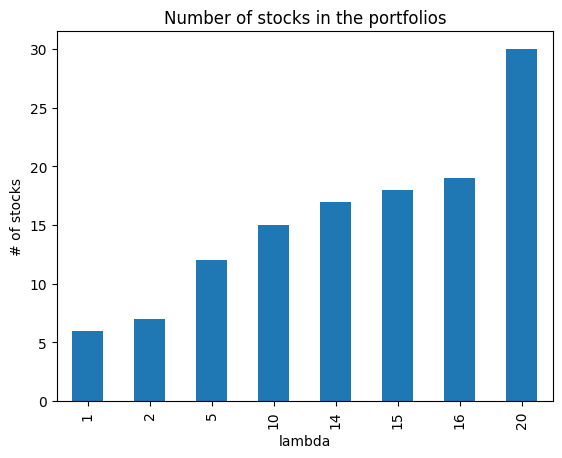

In [81]:
# Number of stocks in the portfolio
riskaverse_number = (riskaverse_weights!=0).sum()
riskaverse_number.plot(kind='bar')
plt.title('Number of stocks in the portfolios')
plt.xlabel('lambda')
plt.ylabel('# of stocks')
plt.show()

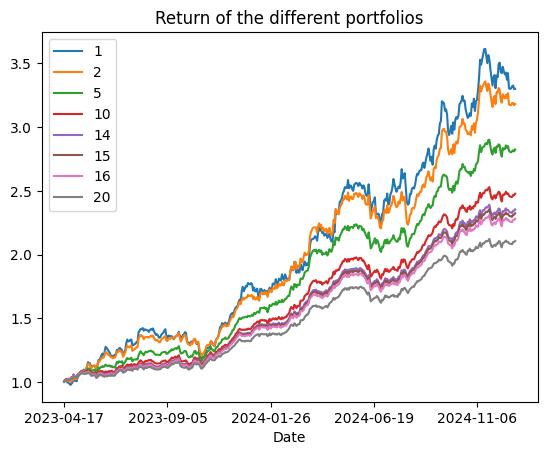

In [82]:
# Returns comparison 
riskaverse_returns_insample = returns_insample@riskaverse_weights
riskaverse_evolution_insample = (1+riskaverse_returns_insample).cumprod()
riskaverse_evolution_insample.plot()

plt.title('Return of the different portfolios')
plt.show()

In [83]:
# Portfolio annualised performances
annualised_returns_insample = 252*riskaverse_returns_insample.mean()
annualised_std_insample = np.sqrt(252)*riskaverse_returns_insample.std()
annualised_SR_insample = (annualised_returns_insample - r_f) / annualised_std_insample

# Maximum drawdown
mdd_insample = (riskaverse_evolution_insample/riskaverse_evolution_insample.cummax()-1).min()

# VaR and CVaR: L = - r@w
loss_insample = - riskaverse_returns_insample
var_insample = loss_insample.quantile(alpha)                               # VaR = Q_L(0.95) = Q_r(0.05)
cvar_insample = (loss_insample[loss_insample>=var_insample]).mean()        # CVaR = E[L|L>=VaR]

# Summary of metrics
summary_insample = np.array([riskaverse_number,annualised_returns_insample,annualised_std_insample,annualised_SR_insample,mdd_insample,var_insample,cvar_insample]).T
summary_insample = pd.DataFrame(np.round(summary_insample,4),index=riskaverse_returns_insample.columns,columns=['number','return','std','SR','MDD','VaR','CVaR'])
print(summary_insample)

    number  return     std      SR     MDD     VaR    CVaR
1      6.0  0.7290  0.2869  2.4570 -0.1700  0.0259  0.0375
2      7.0  0.6955  0.2399  2.7993 -0.1313  0.0230  0.0312
5     12.0  0.6137  0.1761  3.3486 -0.0975  0.0171  0.0225
10    15.0  0.5322  0.1379  3.6846 -0.0846  0.0128  0.0173
14    17.0  0.5017  0.1283  3.7241 -0.0789  0.0119  0.0160
15    18.0  0.4938  0.1261  3.7246 -0.0779  0.0117  0.0158
16    19.0  0.4828  0.1233  3.7210 -0.0768  0.0113  0.0155
20    30.0  0.4358  0.1121  3.6749 -0.0717  0.0101  0.0142


Here, one can see that the greater $\lambda$ is, the lower the standard deviation, the maximum drawdown, the value at risk and the expected shortfall (CVaR) are. This is consistent with the fact that $\lambda >1$ intensifies the risk importance in the Mean-Variance optimisation prolbem. 

So to have a compromise between high return and low risk, we can pick a value for $\lambda$ based on the Sharpe ratio. It yields that the best value seems to be between 14 and 15, let's compute the optimal value!

In [103]:
def negative_sharpe_rartio(l):
    w = cvx.Variable(N)
    constraints = [ cvx.sum(w) == 1, cvx.norm1(w) <= 2]
    objective = cvx.Minimize(l*cvx.quad_form(w,Sigma) - mu.T@w)
    problem = cvx.Problem(objective,constraints)
    problem.solve()

    weight = w.value
    r_p = returns_insample@weight
    SR = (252*r_p.mean()-r_f)/(np.sqrt(252)*r_p.std())

    return - SR

lambda_optimisation = minimize_scalar(negative_sharpe_rartio,bounds=(14,15),method='bounded')
print(lambda_optimisation)

 message: Solution found.
 success: True
  status: 0
     fun: -3.724809747079197
       x: 14.677270651853108
     nit: 9
    nfev: 9


Perfect, the solution has been founded and is around 14.68! Let's check its performances for the out of sample data.

In [98]:
best_lambda = np.round(lambda_optimisation.x,2)

def oos_performances(l):
    w = cvx.Variable(N)
    constraints = [ cvx.sum(w) == 1, cvx.norm1(w) <= 2]
    objective = cvx.Minimize(l*cvx.quad_form(w,Sigma) - mu.T@w)
    problem = cvx.Problem(objective,constraints)
    problem.solve()
    weight = np.round(w.value,4)

    number = (weight!=0).sum()

    r_p = returns_outsample@weight
    avg_returns = 252*r_p.mean()
    std = np.sqrt(252)*r_p.std()
    SR_oos = (avg_returns-r_f)/std

    loss_oos = - r_p
    var_oos = loss_oos.quantile(0.95)
    cvar_oos = loss_oos[loss_oos>=var_oos].mean()

    return number,avg_returns,std,SR_oos,var_oos,cvar_oos

best_summary = np.array(oos_performances(best_lambda)).reshape((1,6))
best_summary = pd.DataFrame(np.round(best_summary,4),index=['best lambda'], columns=['number','return','std','SR','VaR','CVaR'])
print(best_summary)

             number  return     std      SR     VaR   CVaR
best lambda    18.0  0.4272  0.2092  1.9275  0.0141  0.028


So now we finally found a better weights allocation thanks to the risk aversion parameter: 
- The number of stocks rises from 6 to 18.
- The standard deviation drops from 0.47 to 0.21.
- Even though the average return shrank, the Sharpe ratio increases from 1.37 to 1.93. 
- The VaR and CVaR drop respectively from 0.037 to 0.014 and from 0.056 to 0.028.

With a Sharpe ratio greather than 1.92 and a number of stocks of 18, this allocation could be implemented easily and have very decent performances.